In [1]:
# Roopchand Reddy Vanga

In [2]:
! hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [3]:
! hdfs dfs -ls hdfs://nn:9000/

Found 22 items
-rw-r--r--   1 root supergroup        328 2024-11-07 01:44 hdfs://nn:9000/action_taken.csv
-rw-r--r--   1 root supergroup        317 2024-11-07 01:44 hdfs://nn:9000/agency.csv
-rw-r--r--   1 root supergroup     533472 2024-11-07 01:44 hdfs://nn:9000/arid2017_to_lei_xref_csv.csv
-rw-r--r--   1 root supergroup     319092 2024-11-07 01:44 hdfs://nn:9000/counties.csv
-rw-r--r--   1 root supergroup        237 2024-11-07 01:44 hdfs://nn:9000/denial_reason.csv
-rw-r--r--   1 root supergroup        109 2024-11-07 01:44 hdfs://nn:9000/edit_status.csv
-rw-r--r--   1 root supergroup        180 2024-11-07 01:44 hdfs://nn:9000/ethnicity.csv
-rw-r--r--   1 root supergroup  174944099 2024-11-07 01:44 hdfs://nn:9000/hdma-wi-2021.csv
-rw-r--r--   1 root supergroup         41 2024-11-07 01:44 hdfs://nn:9000/hoepa.csv
-rw-r--r--   1 root supergroup        114 2024-11-07 01:44 hdfs://nn:9000/lien_status.csv
-rw-r--r--   1 root supergroup         65 2024-11-07 01:44 hdfs://nn:9000/loan_purpo

In [4]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/07 01:44:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
banks_df = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")
) 

In [6]:
rows = banks_df.rdd.take(3)
rows

[Row(respondent_name='First National Bank', arid_2017='110004', lei_2018='5493003EW6T31TGECO83', lei_2019='5493003EW6T31TGECO83', lei_2020='5493003EW6T31TGECO83'),
 Row(respondent_name='First Mid Bank & Trust, National Association', arid_2017='110045', lei_2018='549300XOTES5TCS8T794', lei_2019='549300XOTES5TCS8T794', lei_2020='549300XOTES5TCS8T794'),
 Row(respondent_name='First Hope Bank, A National Banking Association', arid_2017='110118', lei_2018='5493003XLOX5FDT9R120', lei_2019='5493003XLOX5FDT9R120', lei_2020='5493003XLOX5FDT9R120')]

In [7]:
#q1
bank_count=banks_df.rdd.filter(lambda Row : Row["respondent_name"][:3]=="The").count()
bank_count

298

In [8]:
#q2
banks_df.filter("respondent_name LIKE 'The%'").count()

298

In [9]:
banks_df.write.saveAsTable("banks", mode="overwrite")

24/11/07 01:45:05 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/07 01:45:05 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/11/07 01:45:09 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/11/07 01:45:09 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.4
24/11/07 01:45:10 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/11/07 01:45:12 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/11/07 01:45:12 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/11/07 01:45:12 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/07 01:45:12 W

In [10]:
#q3
spark.sql("select count(*) as count from banks where respondent_name like 'The%'").toPandas()['count'].iloc[0]

298

In [11]:
loans_df = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://nn:9000/hdma-wi-2021.csv")
) 
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

24/11/07 01:45:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [12]:
files = [
    "ethnicity.csv", "race.csv", "sex.csv", "states.csv", 
    "counties.csv", "tracts.csv", "action_taken.csv",
    "denial_reason.csv", "loan_type.csv", "loan_purpose.csv", 
    "preapproval.csv", "property_type.csv"
]

for i in files:
    file_df = (
        spark.read.format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load(f"hdfs://nn:9000/{i}") 
    )
    file_df.createOrReplaceTempView(i[:-4])


In [13]:
#q4
spark.sql("SHOW TABLES").toPandas().set_index('tableName')['isTemporary'].to_dict()

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [14]:
#q5
spark.sql("""
SELECT COUNT(*) as count
FROM banks b
INNER JOIN loans l
ON b.lei_2020 = l.lei
WHERE b.respondent_name='University of Wisconsin Credit Union'
""").toPandas()['count'].iloc[0]

19739

In [15]:
#q6
spark.sql("""
    SELECT COUNT(*) as count
    FROM banks b
    INNER JOIN loans l
    ON b.lei_2020 = l.lei
    WHERE b.respondent_name='University of Wisconsin Credit Union'
""").explain("formatted")


#Q1- Which table is sent to every executor via a BroadcastExchange operation?
#Ans- banks

#Q2 Does the plan involve HashAggregates (depending on how you write the query, it may or may not)?  If so, which ones?
#Ans- HashAggregate (9) - partial aggregation(count), happens after BroadcastHashJoin and before exchange(10) in each partition

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildLeft (7)
               :- BroadcastExchange (4)
               :  +- Project (3)
               :     +- Filter (2)
               :        +- Scan parquet spark_catalog.default.banks (1)
               +- Filter (6)
                  +- Scan parquet spark_catalog.default.loans (5)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#66, lei_2020#70]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#66, lei_2020#70]
Condition : ((isnotnull(respondent_name#66) AND (respondent_name#66 = University of Wisconsin Credit Union)) AND i

In [16]:
spark.sql("""
SELECT respondent_name
FROM banks 
WHERE respondent_name LIKE '%Wells%'
""").toPandas()

,respondent_name
0,Wells Bank
1,"Wells Fargo Bank, National Association"


In [17]:
spark.sql("""
SELECT *
FROM counties 
LIMIT 1
""").toPandas()

,AREA,PERIMETER,CO99_D00_,CO99_D00_I,STATE,COUNTY,NAME,LSAD,LSAD_TRANS
0,52.91341,60.56496,2.0,1.0,2,185,North Slope,4,Borough


In [18]:
interest_columns = [col for col in loans_df.columns if 'interest' in col]

interest_columns

['interest_rate',
 'interest_only_payment',
 'manufactured_home_land_property_interest']

In [19]:
#q7
d=spark.sql("""
    SELECT counties.NAME as name, AVG(loans.interest_rate) as avg_interest_rate
    FROM loans
    INNER JOIN counties
    ON loans.county_code = counties.STATE * 1000 + counties.COUNTY
    INNER JOIN banks
    ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name LIKE "Wells%"
    GROUP BY counties.NAME
    ORDER BY count(*) DESC
    LIMIT 10
""").toPandas().set_index("name")["avg_interest_rate"]

d.to_dict()

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

In [20]:
 !pip3 install matplotlib --break-system-packages


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --break-system-packages


<Axes: xlabel='name'>

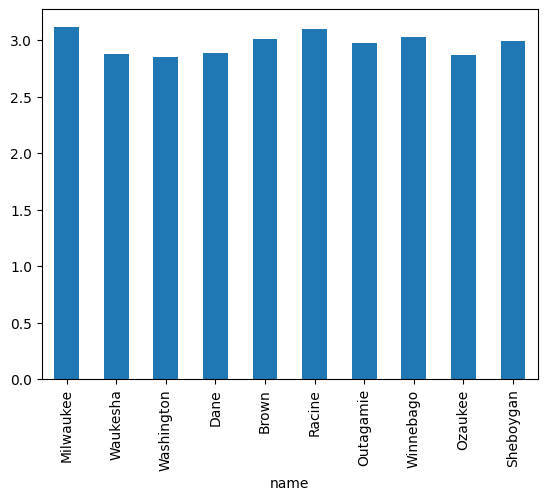

In [21]:
d.plot.bar()

In [22]:
loans_df.dtypes

[('activity_year', 'int'),
 ('lei', 'string'),
 ('derived_msa-md', 'int'),
 ('state_code', 'string'),
 ('county_code', 'string'),
 ('census_tract', 'string'),
 ('conforming_loan_limit', 'string'),
 ('derived_loan_product_type', 'string'),
 ('derived_dwelling_category', 'string'),
 ('derived_ethnicity', 'string'),
 ('derived_race', 'string'),
 ('derived_sex', 'string'),
 ('action_taken', 'int'),
 ('purchaser_type', 'int'),
 ('preapproval', 'int'),
 ('loan_type', 'int'),
 ('loan_purpose', 'int'),
 ('lien_status', 'int'),
 ('reverse_mortgage', 'int'),
 ('open-end_line_of_credit', 'int'),
 ('business_or_commercial_purpose', 'int'),
 ('loan_amount', 'double'),
 ('loan_to_value_ratio', 'string'),
 ('interest_rate', 'string'),
 ('rate_spread', 'string'),
 ('hoepa_status', 'int'),
 ('total_loan_costs', 'string'),
 ('total_points_and_fees', 'string'),
 ('origination_charges', 'string'),
 ('discount_points', 'string'),
 ('lender_credits', 'string'),
 ('loan_term', 'string'),
 ('prepayment_penalt

In [23]:
#q8
spark.sql("""
SELECT AVG(loan_amount)
FROM loans 
GROUP BY county_code
""").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#992], functions=[avg(loan_amount#1009)])
   +- HashAggregate(keys=[county_code#992], functions=[partial_avg(loan_amount#1009)])
      +- FileScan parquet spark_catalog.default.loans[county_code#992,loan_amount#1009] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,loan_amount:double>, SelectedBucketsCount: 8 out of 8




In [24]:
spark.sql("""
SELECT AVG(loan_amount)
FROM loans 
GROUP BY lei
""").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#989], functions=[avg(loan_amount#1009)])
   +- Exchange hashpartitioning(lei#989, 200), ENSURE_REQUIREMENTS, [plan_id=940]
      +- HashAggregate(keys=[lei#989], functions=[partial_avg(loan_amount#1009)])
         +- FileScan parquet spark_catalog.default.loans[lei#989,loan_amount#1009] Batched: true, Bucketed: false (bucket column(s) not read), DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<lei:string,loan_amount:double>




In [25]:
# Ans - Network I/O is necessary for the 2nd query since it is grouped by lei while the data(loans table)
#       is bucketed by county_code. 'exchange' line can also be seen in 2nd query's plan which shows that
#       partial aggregrate(Average/mean) is being exchanged between every partition to find total mean. 

In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.functions import col, expr, when, sum, count 

In [27]:
loans_df.select(["action_taken"]).show()

+------------+
|action_taken|
+------------+
|           6|
|           4|
|           6|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
|           1|
+------------+
only showing top 20 rows



In [28]:
spark.sql("""
SELECT *
FROM action_taken
limit 10
""").toPandas()

,id,action_taken
0,1,Loan originated
1,2,Application approved but not accepted
2,3,Application denied by financial institution
3,4,Application withdrawn by applicant
4,5,File closed for incompleteness
5,6,Loan purchased by the institution
6,7,Preapproval request denied by financial instit...
7,8,Preapproval request approved but not accepted


In [29]:
df=spark.sql("""
SELECT loans.loan_amount AS loan_amount, loans.income AS income, loans.interest_rate AS interest_rate, action_taken.action_taken as approval
FROM loans
LEFT JOIN action_taken
ON loans.action_taken = action_taken.id
""")

df= (
        df
        .withColumn("approval", when(col("approval") == "Loan originated", 1.0).otherwise(0.0))
        #.withColumn("approval", col("approval").cast("double"))
        .withColumn("income", col("income").cast("double"))
        .withColumn("interest_rate", col("interest_rate").cast("double"))
        .fillna(0.0)
)
# approval and loan_amount are already in 'double' format.

In [30]:
df.show()

+-----------+------+-------------+--------+
|loan_amount|income|interest_rate|approval|
+-----------+------+-------------+--------+
|   255000.0| 210.0|          0.0|     1.0|
|   435000.0|   0.0|        3.125|     0.0|
|   435000.0| 190.0|          0.0|     1.0|
|   165000.0|   0.0|         3.25|     0.0|
|   205000.0|   0.0|          0.0|     1.0|
|   305000.0|   0.0|          3.5|     0.0|
|   195000.0|  43.0|         2.75|     1.0|
|   185000.0|   0.0|          3.5|     0.0|
|   265000.0|  93.0|         2.75|     1.0|
|   185000.0|   0.0|         3.25|     0.0|
|   475000.0|   0.0|        1.999|     1.0|
|   235000.0|   0.0|         3.25|     0.0|
|   425000.0|   0.0|          2.0|     1.0|
|   235000.0|   0.0|         3.25|     0.0|
|   185000.0|   0.0|         2.25|     1.0|
|   385000.0|   0.0|          3.0|     0.0|
|   365000.0| 321.0|        2.625|     1.0|
|   155000.0|   0.0|          2.5|     0.0|
|   245000.0|   0.0|         3.75|     1.0|
|   315000.0|   0.0|          3.

In [31]:
df.dtypes

[('loan_amount', 'double'),
 ('income', 'double'),
 ('interest_rate', 'double'),
 ('approval', 'double')]

In [32]:
train, test = df.randomSplit([0.8, 0.2], seed=41) 
train=train.cache()

In [33]:
va = VectorAssembler(inputCols=["loan_amount","income","interest_rate"], outputCol="features")

In [34]:
l=[1, 5, 10, 15, 20]
dict={}
for i in l:
    dt=DecisionTreeClassifier(featuresCol="features", labelCol="approval",maxDepth=i, seed=41)
    model= dt.fit(va.transform(train))
    result=model.transform(va.transform(test))
    df_with_accuracy = result.withColumn("correct", when(col("approval") == col("prediction"), 1).otherwise(0))
    accuracy = df_with_accuracy.agg((sum(col("correct")) / count("*")).alias("accuracy")).first()["accuracy"]
    dict[f"depth={i}"] = accuracy


24/11/07 01:46:15 WARN DAGScheduler: Broadcasting large task binary with size 1082.6 KiB
24/11/07 01:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1375.0 KiB
24/11/07 01:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1695.8 KiB
24/11/07 01:46:16 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/07 01:46:17 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [35]:
#q9
dict

{'depth=1': 0.8809425750509244,
 'depth=5': 0.8929195560947918,
 'depth=10': 0.8954796914480349,
 'depth=15': 0.8948674851679115,
 'depth=20': 0.893943610236089}

In [36]:
#q10

# Ans - Test doesn't always increase with the value of max depth. Higher max depth value leads to an overfit model 
#       hence accuracy on test data might decrease after a point.